In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from scipy import sparse
import dask.dataframe as dd
import dask.bag as db
from dask.delayed import delayed
dir_path = '/content/gdrive/My Drive/netflix/'

In [ ]:
start_time = datetime.now()
if not os.path.isfile(dir_path + 'netflix_data.csv'):
    data = open(dir_path + 'netflix_data.csv', mode='w')
    row = []
    files = [
            dir_path + 'combined_data_1.txt',
            dir_path + 'combined_data_2.txt',
            dir_path + 'combined_data_3.txt',
            dir_path + 'combined_data_4.txt'
        ]
    for file in files:
        print("Reading the file {}...".format(file))
        with open(file) as f:
            for line in f:
                del row[:]
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':','')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0,movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done...")
    data.close()
print("Time Taken =" ,datetime.now()-start_time )

Time Taken = 0:00:00.004070


In [ ]:
df = pd.read_csv(dir_path + 'netflix_data.csv')
df.shape

(100480506, 4)

In [ ]:
# Only run this block when you dont have sorted data by 'time'.
if not os.path.isfile(dir_path + "netflix_sorted_data"): 
    start_time = datetime.now()

    # creating the dataframe with 4 columns; namely 'movies_id','customer','rating','date'.
    print("Creating the dataframe")
    df = pd.read_csv(dir_path + "netflix_data.csv", sep=',', names=['movies_id','customer','rating','date']) 

    # Checking the null value and then delete them if any.
    print("Checking Null values")
    print("Number of nan values: ",sum(df.isnull().any()))
    df = df.dropna(axis=0, inplace= False)

    # Checking the duplicate entries and remove them.
    dups_bool = df.duplicated(['movies_id','customer','rating'])
    dups = sum(dups_bool)
    print("Total number of duplicate entries: {}".format(dups))
    df = df.drop_duplicates()

    # Sorting the dataframe by date column.
    print("Sorting the dataframe")
    df = df.sort_values(by='date', inplace=False)
    print("Done")
    print("Saving... Please wait")
    df.to_csv(dir_path + "netflix_sorted_data", index=False)
    print("Saved")
    print("Time Taken: ", datetime.now()-start_time)
else:
    df = pd.read_csv(dir_path + 'netflix_sorted_data', sep=',' )


In [ ]:
print("Total number of ratings in whole dataset: ", df.shape[0])
print("Total number of Users in whole dataset: ", len(np.unique(df.customer)))
print("Total number of Movies in whole dataset: ",len(np.unique(df.movies_id)))

Total number of ratings in whole dataset:  100480507
Total number of Users in whole dataset:  480189
Total number of Movies in whole dataset:  17770


In [ ]:
df.customer.describe()

count    1.004805e+08
mean     1.322489e+06
std      7.645368e+05
min      6.000000e+00
25%      6.611980e+05
50%      1.319012e+06
75%      1.984455e+06
max      2.649429e+06
Name: customer, dtype: float64

In [ ]:
df.rating.describe()

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

<h2>Spliting the data into Train, Cross Validate and Test dataset.</h2>

In [ ]:
#saving the datasets and loading them.
start = datetime.now()
if not os.path.isfile(dir_path + "train.csv"):
  df.iloc[:int(df.shape[0]*0.6)].to_csv(dir_path + "train.csv")

if not os.path.isfile(dir_path + "cv.csv"):
  df.iloc[int(df.shape[0]*0.6):int(df.shape[0]*0.8)].to_csv(dir_path + "cv.csv")

if not os.path.isfile(dir_path + "test.csv"):
  df.iloc[int(df.shape[0]*0.8):].to_csv(dir_path + "test.csv")
print("Time Taken: ",datetime.now()-start)

train_df = pd.read_csv(dir_path + "train.csv", parse_dates=['date'])
cv_df = pd.read_csv(dir_path + "cv.csv", parse_dates=['date'])
test_df = pd.read_csv(dir_path + "test.csv", parse_dates=['date'])
print("Datasets loaded successfully.")

Time Taken:  0:00:00.001880


<h2> Statistic on dataset

In [ ]:
# This block tells you no. of datapoints in a dataset ,no. of rating, no. of unique users and movies
print("Train Dataset")
print("-"*50)
print("Number of datapoints: ",train_df.shape[0],"(", np.round((train_df.shape[0]/(train_df.shape[0]+cv_df.shape[0]+test_df.shape[0]))*100),3,"%",")")
print("\nNumber of ratings: {}".format(train_df.rating.shape[0]))
print("Number of users: {}".format(len(np.unique(train_df.customer))))
print("Number of movies: {}".format(len(np.unique(train_df.movies_id))))
print("\n")
print("Cross Validate Dataset")
print("-"*50)
print("Number of datapoints: ",cv_df.shape[0],"(", np.round((cv_df.shape[0]/(train_df.shape[0]+cv_df.shape[0]+test_df.shape[0]))*100),3,"%",")")
print("\nNumber of ratings: {}".format(cv_df.rating.shape[0]))
print("Number of users: {}".format(len(np.unique(cv_df.customer))))
print("Number of movies: {}".format(len(np.unique(cv_df.movies_id))))
print("\n")
print("Test Dataset")
print("-"*50)
print("Number of datapoints: ",test_df.shape[0],"(", np.round((test_df.shape[0]/(train_df.shape[0]+cv_df.shape[0]+test_df.shape[0]))*100),3,"%",")")
print("\nNumber of ratings: {}".format(test_df.rating.shape[0]))
print("Number of users: {}".format(len(np.unique(test_df.customer))))
print("Number of movies: {}".format(len(np.unique(test_df.movies_id))))

Train Dataset
--------------------------------------------------
Number of datapoints:  60288304 ( 60.0 3 % )

Number of ratings: 60288304
Number of users: 328767
Number of movies: 16464


Cross Validate Dataset
--------------------------------------------------
Number of datapoints:  20096101 ( 20.0 3 % )

Number of ratings: 20096101
Number of users: 327155
Number of movies: 17386


Test Dataset
--------------------------------------------------
Number of datapoints:  20096102 ( 20.0 3 % )

Number of ratings: 20096102
Number of users: 349312
Number of movies: 17757


In [ ]:
def human(num , units = 'M'):
  units = units.lower()
  num = float(num)
  if units == 'k':
    return str(num/10**3) + 'K'
  if units == 'm':
    return str(num/10**6) + 'M'
  if units == 'b':
    return str(num/10**9) + 'B'
    

In [ ]:
print("Occurance of each rating in train dataset.\n")
train_df.rating.value_counts()

Occurance of each rating in train dataset.



4    20394785
3    17726270
5    12650808
2     6595195
1     2921246
Name: rating, dtype: int64

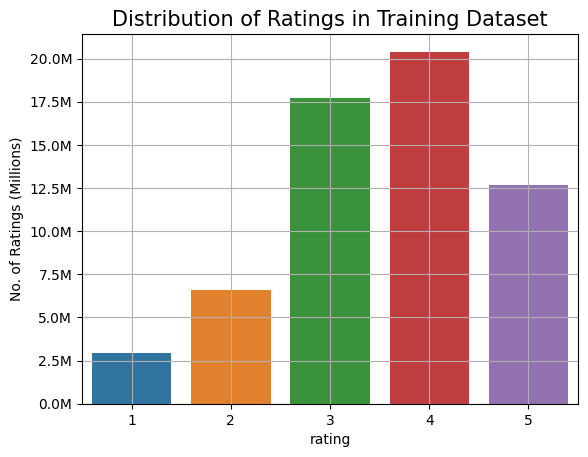

In [ ]:

fig, ax = plt.subplots()
plt.title('Distribution of Ratings in Training Dataset', fontsize=15)
sns.countplot(x= train_df.rating)
ax.set_ylabel('No. of Ratings (Millions)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.grid()
plt.show()

In [ ]:
pd.options.mode.chained_assignment = None
train_df['days_of_week'] = train_df.date.dt.day_name()
train_df.tail(10)

,Unnamed: 0,movies_id,customer,rating,date,days_of_week
60288294,60288294,1305,1329779,2,2005-03-29,Tuesday
60288295,60288295,15922,2013981,3,2005-03-29,Tuesday
60288296,60288296,4783,1487570,3,2005-03-29,Tuesday
60288297,60288297,12881,1568289,4,2005-03-29,Tuesday
60288298,60288298,13856,2344231,5,2005-03-29,Tuesday
60288299,60288299,12244,2030941,4,2005-03-29,Tuesday
60288300,60288300,13856,1722187,5,2005-03-29,Tuesday
60288301,60288301,3368,1789985,4,2005-03-29,Tuesday
60288302,60288302,10230,28531,2,2005-03-29,Tuesday
60288303,60288303,7589,1135584,4,2005-03-29,Tuesday


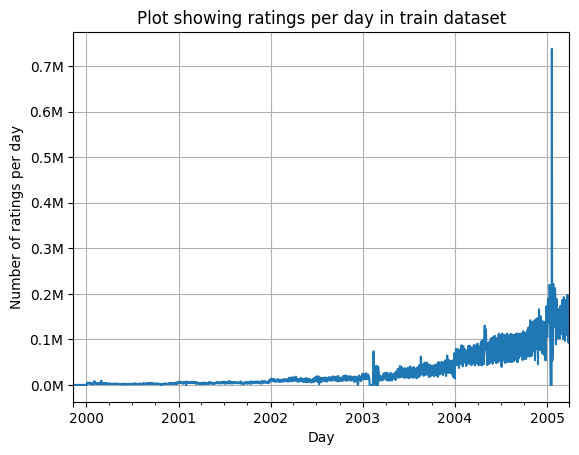

In [ ]:
ax = train_df.resample('d' , on='date')['rating'].count().plot()
ax.set_yticklabels([human(item,'M') for item in ax.get_yticks()])
ax.set_title("Plot showing ratings per day in train dataset")
plt.xlabel("Day")
plt.ylabel("Number of ratings per day")
plt.grid()
plt.show()

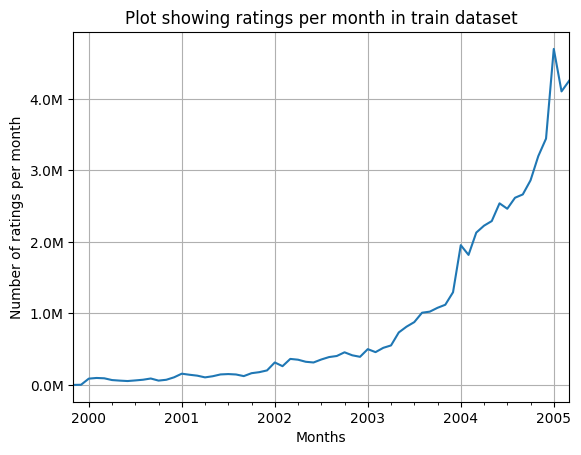

In [ ]:
ax = train_df.resample('m' , on='date')['rating'].count().plot()
ax.set_yticklabels([human(item,'M') for item in ax.get_yticks()])
ax.set_title("Plot showing ratings per month in train dataset")
plt.xlabel("Months")
plt.ylabel("Number of ratings per month")
plt.grid()
plt.show()

In [ ]:
print("Number of ratings given by top 5 users.")
no_of_rating_per_user = train_df.groupby(by='customer')['rating'].count().sort_values(ascending = False)
no_of_rating_per_user.head()

Number of ratings given by top 5 users.


customer
305344     15998
2439493    14733
387418     14124
1639792     9748
1932594     7398
Name: rating, dtype: int64

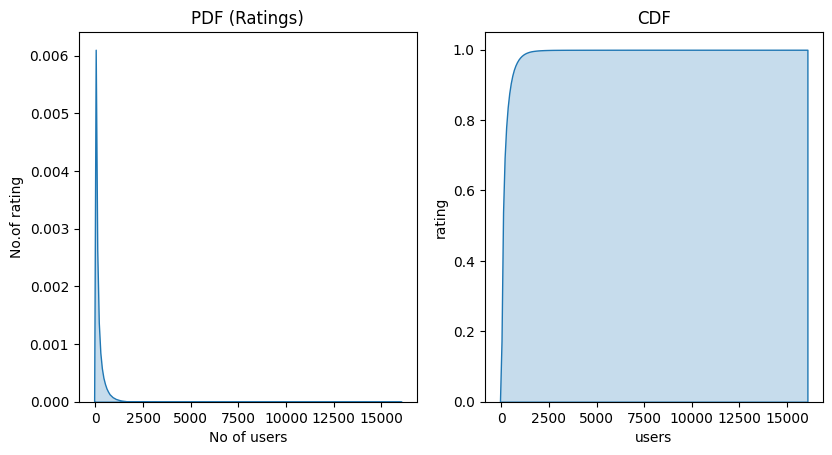

In [ ]:
fig = plt.figure(figsize = plt.figaspect(.5))
ax1 = plt.subplot(1,2,1)
plt.title("PDF (Ratings)")
plt.xlabel("No of users")
plt.ylabel("No.of rating")
sns.kdeplot(no_of_rating_per_user, ax=ax1,shade= True)

ax2= plt.subplot(1,2,2)
plt.title("CDF")
plt.xlabel('users')
plt.ylabel('rating')
sns.kdeplot(no_of_rating_per_user,cumulative = True, ax = ax2, shade = True)
plt.show()

In [ ]:
no_of_rating_per_user.describe()

count    328767.000000
mean        183.376993
std         276.787794
min           1.000000
25%          26.000000
50%          81.000000
75%         226.000000
max       15998.000000
Name: rating, dtype: float64

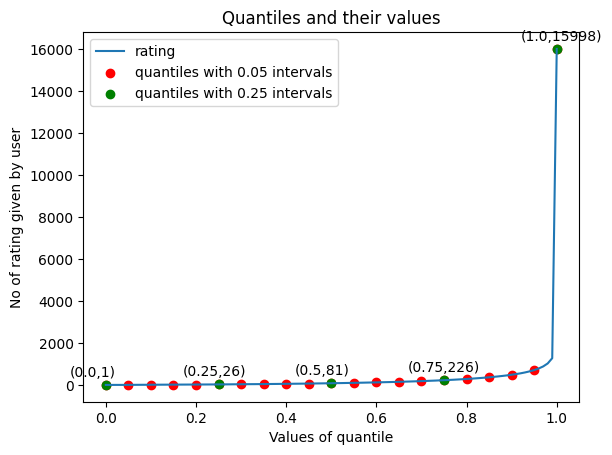

In [ ]:
quantiles = no_of_rating_per_user.quantile(np.arange(0,1.01,0.01), interpolation = 'higher')
quantiles.plot()
plt.title("Quantiles and their values")
plt.xlabel("Values of quantile")
plt.ylabel("No of rating given by user")
# quantiles with 0.05 intervals
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], color='red',label= "quantiles with 0.05 intervals")
# quantiles with 0.25 intervals
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25],color='green',label='quantiles with 0.25 intervals')
plt.legend(loc = 'best')

for x,y in zip(quantiles.index[::25], quantiles.values[::25]):
  ''' s="({} , {})".format(x, y) sets the content of the annotation to a formatted string that includes the values of x and y.
      For example, if x is 0.25 and y is 500, the annotation will display "(0.25, 500)".

      xy=(x, y) specifies the coordinates on the plot where the annotation arrow will point to. It corresponds to the x and y values
      obtained from the quantiles array.

      xytext=(x-0.05, y+500) sets the coordinates where the annotation text will be placed. It determines the position of the text 
      relative to the annotation point. In this case, x-0.05 shifts the text slightly to the left of the annotation point, and y+500 
      moves the text upward.'''
  plt.annotate(text="({},{})".format(x,y), xy=(x,y), xytext=(x-0.08,y+400))

In [ ]:
print("Quantiles of ratings from 1 to 100 with interval of 5")
quantiles[::5]

Quantiles of ratings from 1 to 100 with interval of 5


0.00        1
0.05        4
0.10        9
0.15       15
0.20       20
0.25       26
0.30       33
0.35       42
0.40       53
0.45       66
0.50       81
0.55      100
0.60      122
0.65      149
0.70      183
0.75      226
0.80      284
0.85      364
0.90      486
0.95      707
1.00    15998
Name: rating, dtype: int64

In [ ]:
print("No of ratinga at last 5 percentile: ",sum(no_of_rating_per_user>707))

No of ratinga at last 5 percentile:  16419


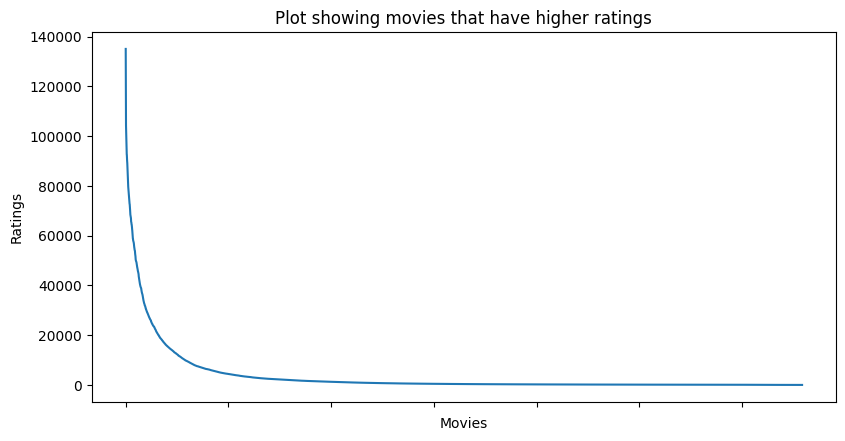

In [ ]:
no_of_movies_per_rate = train_df.groupby(by ='movies_id')['rating'].count().sort_values(ascending=False)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca() #Get Current Axes
plt.plot(no_of_movies_per_rate.values)
plt.title("Plot showing movies that have higher ratings")
plt.xlabel("Movies")
plt.ylabel("Ratings")
ax.set_xticklabels([])
plt.show()

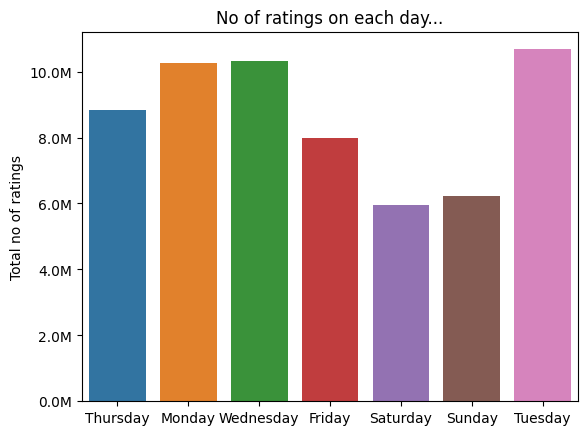

In [ ]:
fig, ax = plt.subplots()
sns.countplot(x='days_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

In [ ]:
avg_week_df = train_df.groupby(by=['days_of_week'])['rating'].mean()
print(" Average ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 Average ratings
------------------------------
days_of_week
Friday       3.551549
Monday       3.547009
Saturday     3.559087
Sunday       3.562834
Thursday     3.551846
Tuesday      3.542370
Wednesday    3.554788
Name: rating, dtype: float64




In [ ]:
start = datetime.now()
if os.path.isfile(dir_path + 'train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    train_sparse_matrix = sparse.load_npz(dir_path + 'train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.customer.values,train_df.movie.values)),)
    
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(dir_path + "train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')
print('It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
It's shape is : (user, movie) :  (2649430, 17771)
0:00:02.745584


In [ ]:
tr_us,tr_mv = train_sparse_matrix.shape
tr_element = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(tr_element/(tr_us*tr_mv))) * 100) )

Sparsity Of Train matrix : 99.95731773201085 % 


In [ ]:
start = datetime.now()
if os.path.isfile(dir_path + 'cv_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    cv_sparse_matrix = sparse.load_npz(dir_path + 'cv_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    cv_sparse_matrix = sparse.csr_matrix((cv_df.rating.values, (cv_df.customer.values,cv_df.movie.values)),)
    
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(dir_path + "cv_sparse_matrix.npz", cv_sparse_matrix)
    print('Done..\n')
print("It\'s shape is : (user, movie) : ",cv_sparse_matrix.shape)
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
It's shape is : (user, movie) :  (2649430, 17771)
0:00:01.745981


In [ ]:
cv_us,cv_mv = cv_sparse_matrix.shape
cv_element = cv_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(tr_element/(cv_us*cv_mv))) * 100) )

Sparsity Of Train matrix : 99.95731773201085 % 


In [ ]:
start = datetime.now()
if os.path.isfile(dir_path + 'test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    test_sparse_matrix = sparse.load_npz(dir_path + 'test_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.customer.values,test_df.movie.values)),)
    
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(dir_path + "test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')
print('It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
It's shape is : (user, movie) :  (2649430, 17771)
0:00:00.928532


In [ ]:
te_us,te_mv = test_sparse_matrix.shape
te_element = test_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(te_element/(te_us*te_mv))) * 100) )

Sparsity Of Train matrix : 99.95731772988694 % 


In [ ]:
def get_average_ratings(sparse_matrix , of_user):
  # chose ax=1 if of_user is True, 0 other wise.
  ax=1 if of_user else ax=0
  # A1 is used to convert the column matrix into 1-d array.
  # Represents the sum of ratings for that user or movie,
  sum_of_ratings = sparse_matrix.sum(axis=ax).A1
  # Create the boolean matrix denoting whether the user rated the movie or not.
  is_rated = sparse_matrix != 0
  # Represents the number of ratings received by that user or movie.
  no_of_ratings = is_rated.sum(axis=ax).A1
  u, m = sparse_matrix.shape
  # This line of code creates a dictionary where the keys are user or movie IDs, and the values are the corresponding average ratings.
  # The comprehension filters out IDs with zero ratings and calculates the average rating for the remaining IDs by dividing the 
  # sum of ratings by the number of ratings.
  average_rating = {i: sum_of_ratings[i] / no_of_ratings[i] for i in range(u if of_user else m) if(no_of_ratings[i] != 0)}
  return average_rating